In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support

sns.set()

In [ ]:
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')
start_time = datetime.now()

In [ ]:
def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):
    """
    Develops and displays a histogram and a scatter plot for a dependent / independent variable pair from
    a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).
    
    Also optionally, if an independent feature is not informed, the scatterplot is not displayed.
    
    Keyword arguments:
    
    f_data      Tensor containing the dependent / independent variable pair.
                Pandas dataframe
    f_y_feature Dependent variable designation.
                String
    f_x_feature Independent variable designation.
                String
    f_index     If greater or equal to zero, the observation denoted by f_index will be plotted in red.
                Integer
    """
    for f_row in f_data:
        if f_index >= 0:
            f_color = np.where(f_data[f_row].index == f_index,'r','g')
            f_hue = None
        else:
            f_color = 'b'
            f_hue = None
    
    f_fig, f_a = plt.subplots(1, 2, figsize=(16,4))
    
    f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='orangered')
    f_chart1.set_xlabel(f_x_feature,fontsize=10)
    
    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False)
        f_chart2.set_xlabel(f_x_feature,fontsize=10)
        f_chart2.set_ylabel(f_y_feature,fontsize=10)

    plt.show()


def correlation_map(f_data, f_feature, f_number):
    """
    Develops and displays a heatmap plot referenced to a primary feature of a dataframe, highlighting
    the correlation among the 'n' mostly correlated features of the dataframe.
    
    Keyword arguments:
    
    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    f_number    The number of features most correlated to the primary feature.
                Integer
    """
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(40, 20))
        f_map = sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                            center=0, cmap="RdYlBu")
    plt.show()

In [ ]:
# Importing the dataset
dataset = pd.read_csv('/content/drive/MyDrive/ADM/WinnipegDataset - Copy.txt')
dataset = dataset.sample(frac=1)

In [ ]:
dataset.head()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
310427,6,-18.3180,-28.343,-16.5240,-20.043,-17.3340,-19.964,-1.79480,-10.0250,-11.8190,-0.078892,2.7094,2.6305,0.38297,0.038080,0.57895,0.25744,0.48041,0.26216,-1.23400,-1.27920,-0.65764,-1.22760,-0.11080,-1.24670,0.024260,0.013174,0.001024,0.68648,0.85574,46.501,0.58745,0.099033,0.26829,0.045229,0.042214,0.10652,-17.3340,-17.3240,-28.343,...,1.00000,1.00000,5900,5299,3379,4533,8397,0.426120,2.4851,1.5682,-0.80530,0.81459,0.63915,0.22125,0.226200,0.76079,0.298840,1.8524,0.298840,355420.0,0.145850,4078.60,146040.0,1.34150,48.778,0.17284,0.77778,0.44444,0.44444,1.42710,0.28395,0.40089,2.5556,0.24691,0.66667,0.66667,0.66667,1.27300,0.30864,-0.31623
23537,1,-9.6372,-17.938,-8.4314,-11.446,-8.9393,-11.614,-1.20580,-8.3004,-9.5062,0.167920,2.5071,2.6750,0.40520,0.059928,0.53487,0.26715,0.47584,0.25701,-0.67894,-0.87935,-0.70723,-0.63298,-0.18315,-0.77639,0.194680,0.062497,0.011116,0.64083,0.69799,46.867,0.44729,0.193530,0.25070,0.108470,0.057098,0.16573,-8.9393,-9.0466,-17.938,...,1.00000,1.00000,5850,4802,2429,3641,10660,0.628850,4.3886,1.9769,-1.10390,1.20520,0.94324,0.32817,0.378860,0.91199,0.490800,2.9278,0.490800,643320.0,0.199670,4680.20,167640.0,1.49900,44.444,0.24691,0.72222,0.55556,0.55556,1.31080,0.28395,-0.15811,0.0000,0.00000,1.00000,0.00000,0.00000,-0.00000,1.00000,1.00000
170817,4,-20.0980,-29.579,-18.3930,-23.072,-18.2320,-22.672,-1.70500,-9.4808,-11.1860,-0.400560,4.8397,4.4392,0.38558,0.043454,0.57097,0.19439,0.59244,0.21317,-1.50290,-1.46060,-0.90983,-1.53480,-0.19278,-1.46710,0.016153,0.008322,0.000882,0.70069,0.80826,39.489,0.56634,0.134350,0.24192,0.057388,0.054628,0.13920,-18.2320,-20.3470,-29.579,...,1.00000,1.00000,6302,5239,2872,4377,10127,0.558120,3.5261,1.8242,-0.91120,1.11660,0.83715,0.29183,0.318100,0.87267,0.396440,2.3137,0.396440,526120.0,0.207610,5303.20,184980.0,1.52400,45.222,0.17284,0.88889,0.22222,0.22222,1.00270,0.48148,0.35714,2.0000,0.00000,1.00000,0.00000,0.00000,-0.00000,1.00000,1.00000
312651,6,-17.1320,-28.244,-16.3840,-19.722,-16.6240,-19.419,-0.74792,-11.1120,-11.8600,-0.303650,3.0984,2.7948,0.44144,0.034168,0.52440,0.24311,0.49618,0.26071,-1.96480,-1.40310,-0.75949,-1.94340,-0.11017,-1.86070,0.024527,0.018220,0.001101,0.71220,0.88600,45.561,0.63100,0.081194,0.25499,0.032811,0.044906,0.10047,-16.6240,-16.8630,-28.244,...,0.43210,-0.25000,5965,5083,3208,4010,8194,0.437290,2.5542,1.5845,-0.72075,0.89566,0.65591,0.22615,0.234310,0.77077,0.342840,2.0434,0.342840,387290.0,0.111110,3210.80,123120.0,1.25000,49.222,0.17284,0.88889,0.22222,0.22222,0.52971,0.65432,-0.12500,2.0000,0.00000,1.00000,0.00000,0.00000,-0.00000,1.00000,1.00000
308463,6,-16.1040,-25.302,-15.1070,-19.087,-14.9710,-18.493,-0.99637,-9.1981,-10.1940,-0.594500,4.1163,3.5218,0.42049,0.050576,0.52893,0.21156,0.54584,0.24260,-2.15500,-1.87270,-1.25870,-2.79000,-0.22755,-1.86520,0.033035,0.022670,0.002620,0.75428,0.79279,42.448,0.59799,0.156290,0.19480,0.050915,0.079313,0.17969,-14.9710,-16.2820,-25.302,...,0.20988,0.36084,6337,5703,4928,4918,5912,0.090775,1.1997,1.1573,-0.20421,0.25374,0.13616,0.07290,0.017994,0.27762,0.091782,1.2021,0.091782,97310.0,-0.001016,440.04,30400.0,0.99797,54.000,0.00000,1.00000,0.00000,0.00000,-0.00000,1.00000,1.00000,4.7778,0.17284,0.88889,0.22222,0.22222,0.99503,0.40741,0.59761


In [ ]:
class_share = pd.Series(100 * dataset.label.value_counts(normalize=True)).sort_index()
print('Class share\n')
for i in range(0,7):
    print(f'Class {class_share.index[i]}: {class_share.iloc[i]:.2f} %')

Class share

Class 1: 12.02 %
Class 2: 1.10 %
Class 3: 23.22 %
Class 4: 22.73 %
Class 5: 14.46 %
Class 6: 26.11 %
Class 7: 0.35 %


Text(0, 0.5, 'Share (%)')

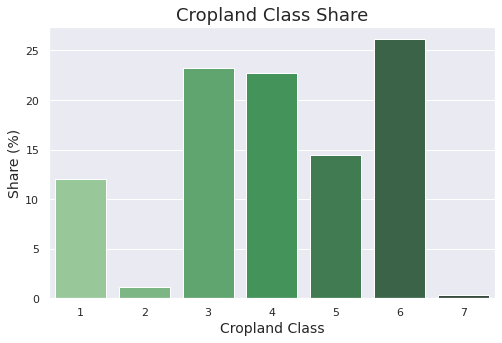

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(ax=ax, x = class_share.index, y = class_share, palette='Greens_d')
plt.title('Cropland Class Share', fontsize=18)
plt.xlabel('Cropland Class', fontsize=14)
plt.ylabel('Share (%)', fontsize=14)

In [ ]:
highly_correlated_feature_pairs = []
highly_correlated_features_to_drop = []

correlation_matrix = dataset.corr().abs()
upper_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
for row in range(upper_matrix.shape[0]):
    for column in range(upper_matrix.shape[1]):
        if upper_matrix.iloc[row, column] > 0.95:
            highly_correlated_feature_pairs.append([row, column, upper_matrix.iloc[row, column]])
            
print(f'Number of highly intercorrelated feature pairs: {len(highly_correlated_feature_pairs)}')

Number of highly intercorrelated feature pairs: 117


In [ ]:
highly_correlated_feature_pairs = pd.DataFrame(highly_correlated_feature_pairs).sort_values(by=[2], ascending=False)
highly_correlated_feature_pairs.columns = ['feature_1', 'feature_2', 'correl']
highly_correlated_feature_pairs.head(10)

,feature_1,feature_2,correl
4,2,39,1.000000
38,51,88,1.000000
109,151,153,1.000000
45,54,86,1.000000
8,5,37,1.000000
102,142,147,1.000000
113,156,157,0.998716
13,7,15,0.995524
10,6,38,0.995455
60,62,79,0.995254


In [ ]:
highly_correlated_features_to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.95)]
dataset = dataset.drop(dataset[highly_correlated_features_to_drop], axis=1)

In [ ]:
nr_features = dataset.shape[1] - 1
print(f'Optimized number of features: {nr_features}')

Optimized number of features: 102


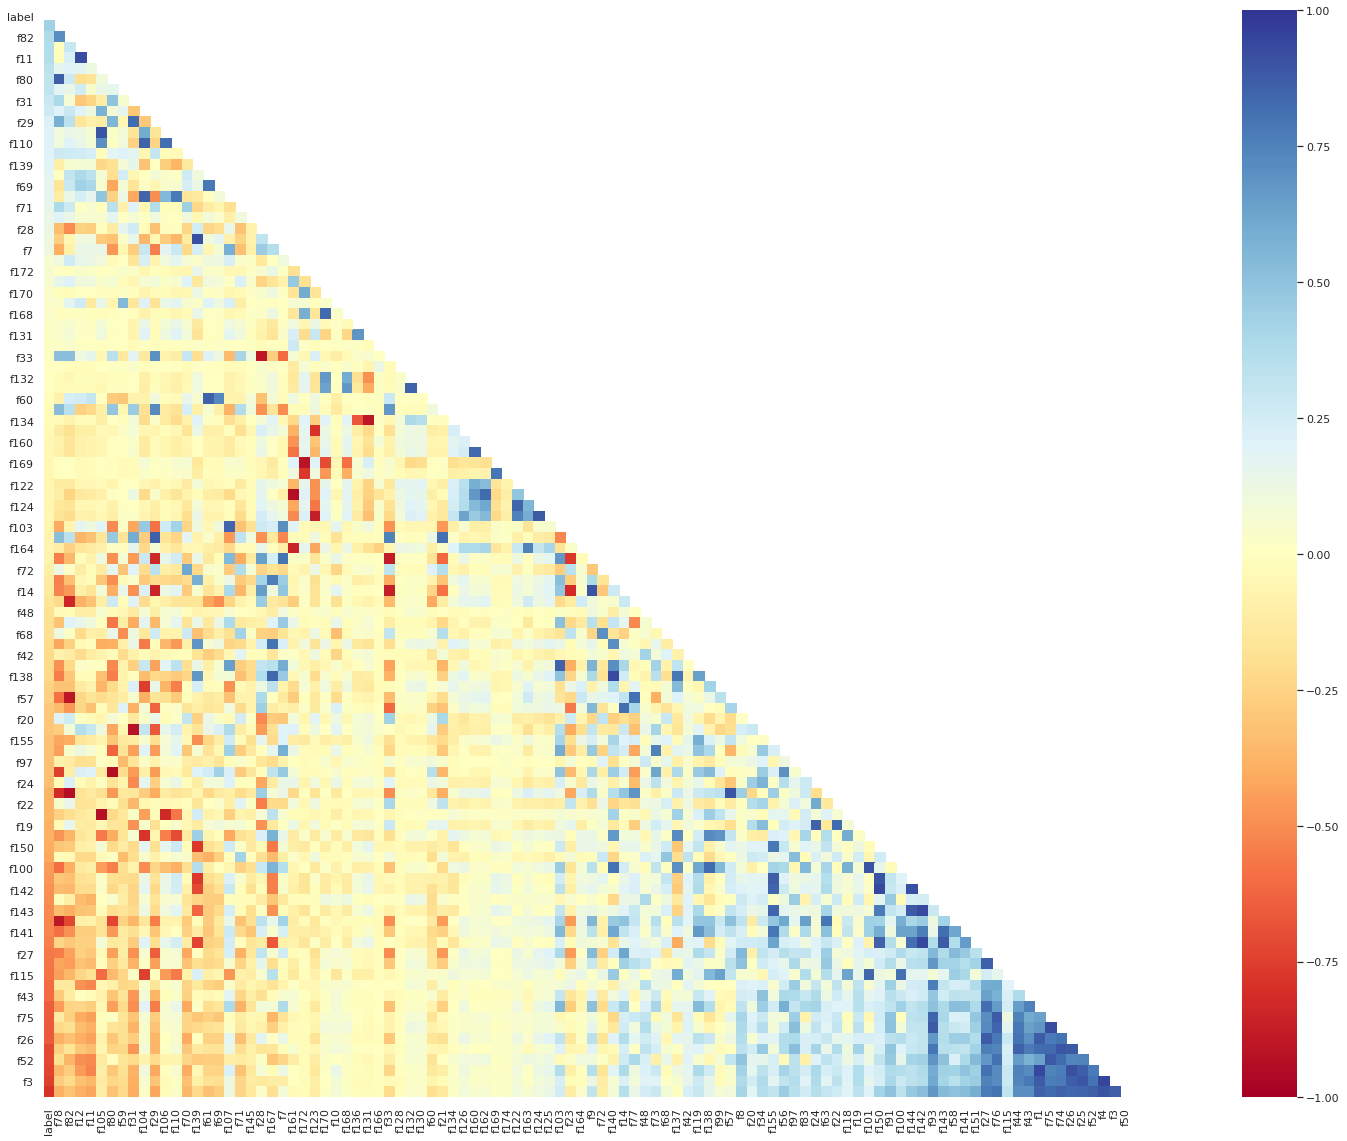

In [ ]:
correlation_map(dataset, 'label', nr_features)

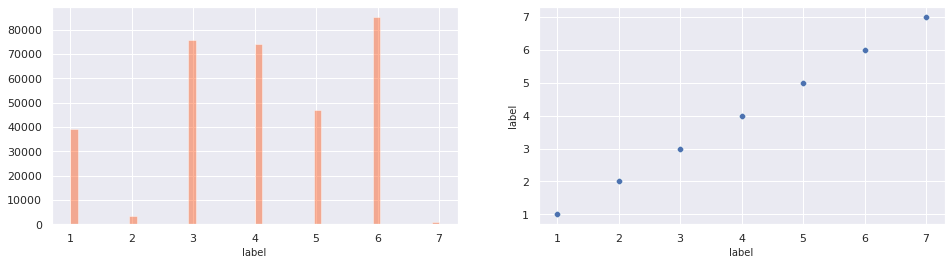

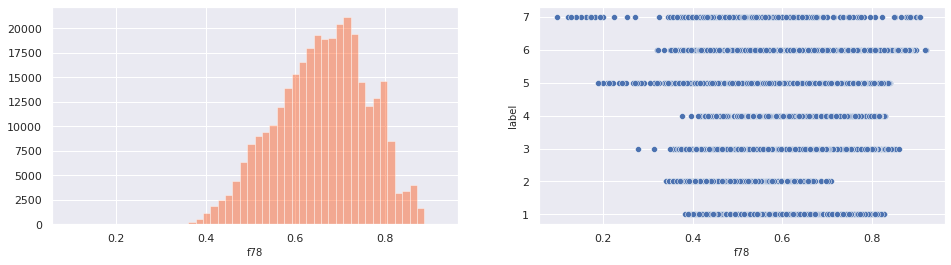

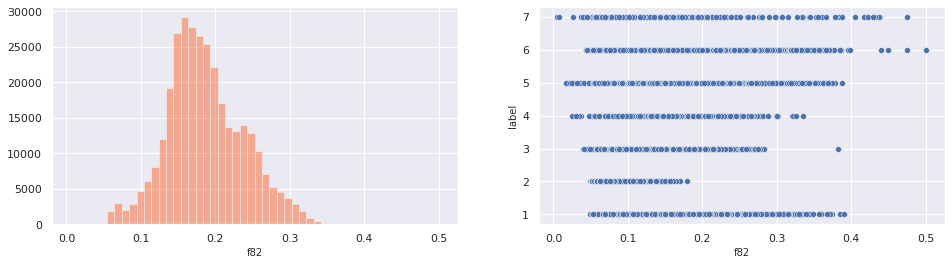

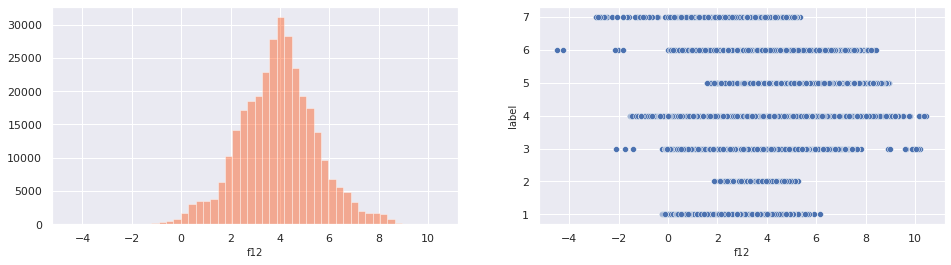

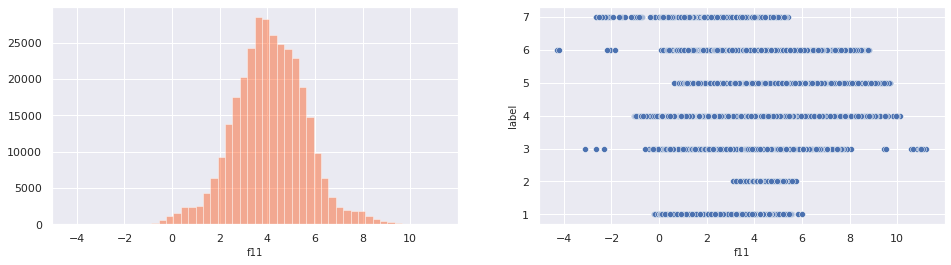

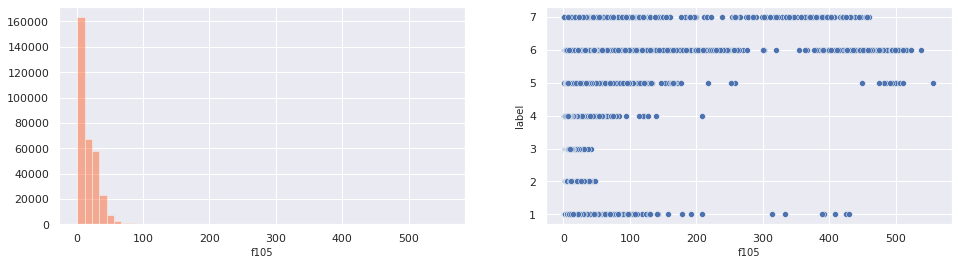

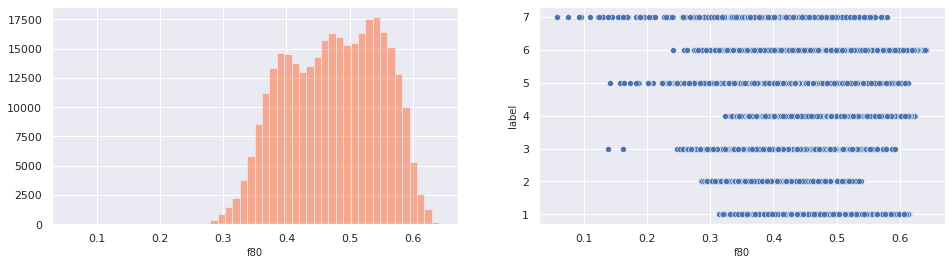

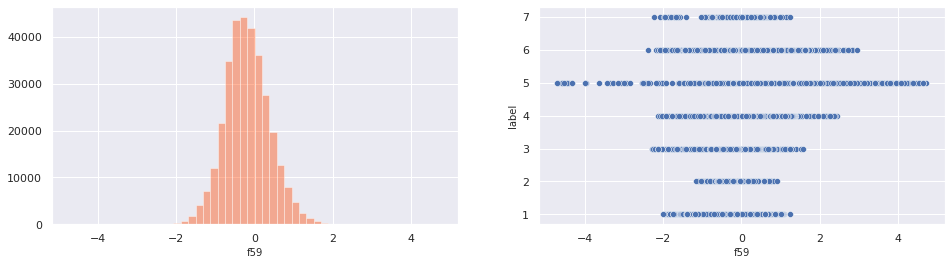

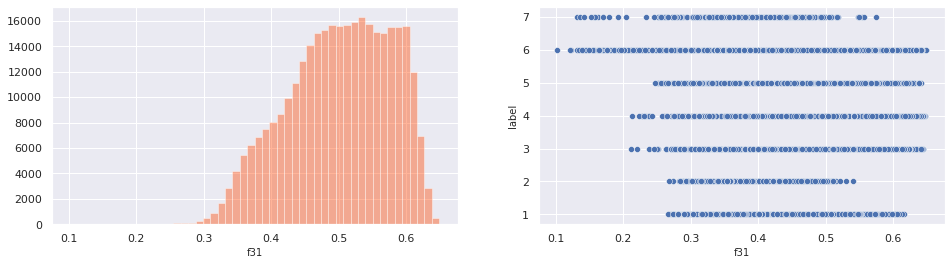

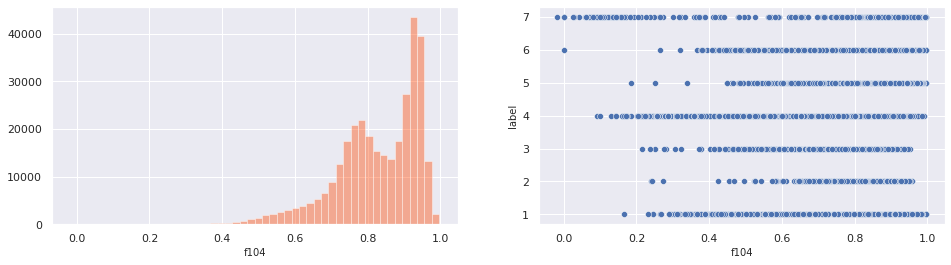

In [ ]:
most_correlated_features = dataset.corr().nlargest(10,'label')['label'].index

for column in most_correlated_features:
    assessment(dataset, 'label', column, -1)

In [ ]:
dataset.shape

(325834, 103)

In [ ]:
dataset.to_csv('/content/drive/MyDrive/ADM/WinnipegDataset_PCA.csv', index=False)